In [1]:
%run homework_modules.ipynb

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1 часть. Реализуем оптимизатор

In [4]:
class Adam:
    def __init__(self, model, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.params = []
        self.grads = []
        
        for module in model.layers.modules:
            if hasattr(module, 'W'):
                self.params.append(module.W)
                self.grads.append(module.gradW)
            if hasattr(module, 'b'):
                self.params.append(module.b)
                self.grads.append(module.gradb)

            if hasattr(module, 'gamma'):
                self.params.append(module.gamma)
                self.grads.append(module.gradGamma)
            if hasattr(module, 'beta'):
                self.params.append(module.beta)
                self.grads.append(module.gradBeta)
        
        #инициализация моментов
        self.m = [np.zeros_like(p) for p in self.params]
        self.v = [np.zeros_like(p) for p in self.params]

    def step(self):
        """Обновляет параметры"""
        self.t += 1
        lr_t = self.lr * np.sqrt(1 - self.beta2**self.t) / (1 - self.beta1**self.t)
        
        for i, param in enumerate(self.params):
            if self.grads[i] is None:
                continue
                
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * self.grads[i]
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (self.grads[i]**2)
            param -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + self.eps)

    def zero_grad(self):
        """Обнуляет градиенты"""
        for grad in self.grads:
            if grad is not None:
                grad.fill(0)

# 2 часть. Мультирегрессия

*Сгенерируем данные*

In [7]:
import numpy as np

np.random.seed(42)
n_samples = 15000  
n_features = 10
n_targets = 3

X = np.random.randn(n_samples, n_features)
true_weights = np.random.randn(n_features, n_targets)
y = X @ true_weights + 0.1 * np.random.randn(n_samples, n_targets)  

*Разделим выборку*

In [9]:
X_train = X[:12000]
X_val = X[12000:13500]
X_test = X[13500:]
y_train = y[:12000]
y_val = y[12000:13500]
y_test = y[13500:]

**Создадим маленькую сеть, используя наши классы**

In [11]:
class SmallRegressionModel(Module):
    def __init__(self, input_size, hidden_size=64, output_size=3, dropout_p=0.2):
        super().__init__()
        self.layers = Sequential()
        self.layers.add(Linear(input_size, hidden_size))
        self.layers.add(BatchNormalization())
        self.layers.add(ReLU())
        self.layers.add(Dropout(dropout_p))
        self.layers.add(Linear(hidden_size, output_size))
    
    def forward(self, x):
        return self.layers.forward(x)
    
    def backward(self, x, grad_output):
        return self.layers.backward(x, grad_output)

    def getParameters(self):
        """Возвращает список всех параметров модели"""
        params = []
        for module in self.layers.modules:
            if hasattr(module, 'getParameters'):
                params.extend(module.getParameters())
        return params
    
    def setParameters(self, new_params):
        """Устанавливает новые параметры для модели"""
        idx = 0
        for module in self.layers.modules:
            if hasattr(module, 'getParameters'):
                module_params = module.getParameters()
                for i in range(len(module_params)):
                    module_params[i][:] = new_params[idx] 
                    idx += 1

*Добавим шедулер в виде косинуса*

In [13]:
class CosineAnnealingLR:
    def __init__(self, optimizer, T_max=10, eta_min=1e-5):
        self.optimizer = optimizer
        self.T_max = T_max      #период цикла
        self.eta_min = eta_min  #минимальный LR
        self.epoch = 0
    
    def step(self):
        self.epoch += 1
        lr = self.eta_min + 0.5 * (self.optimizer.lr - self.eta_min) * \
             (1 + np.cos(np.pi * self.epoch / self.T_max))
        self.optimizer.lr = lr

*Добавим раннюю остановку*

In [15]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_weights = None
        self.early_stop = False
        self.best_epoch = 0

    def __call__(self, model, current_loss, epoch):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            self.best_epoch = epoch
            # Сохраняем все обучаемые параметры модели
            self.best_weights = [param.copy() for param in model.getParameters()]
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [16]:
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / (ss_tot + 1e-8))

**Инициализация модели**

In [18]:
model = SmallRegressionModel(input_size=n_features)
criterion = MSECriterion()
optimizer = Adam(model, lr=0.001)
scheduler = CosineAnnealingLR(optimizer)
early_stopping = EarlyStopping(patience=20, min_delta=0.001)

*Обучаем модель с отрисовкой лосса и R^2*

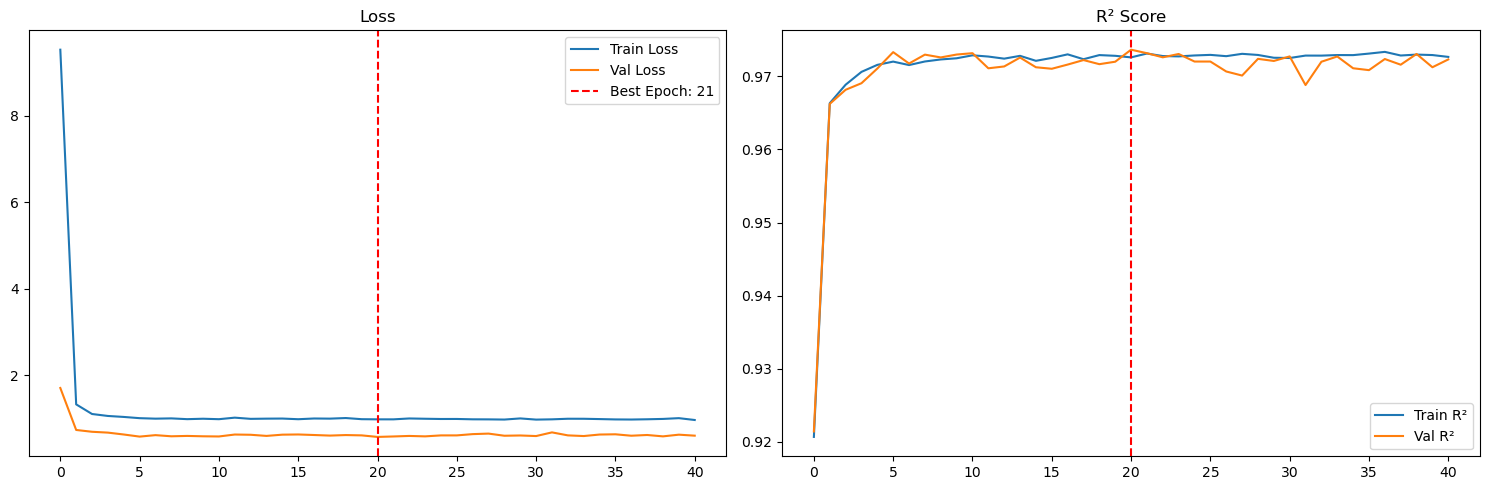

Epoch 41/100
Train Loss: 0.9630 | Val Loss: 0.6004
Train R²: 0.9727 | Val R²: 0.9723
Learning Rate: 0.000010
Best Val Loss: 0.5716 at epoch 21

 Early stopping


In [20]:
batch_size = 64
epochs = 100

train_loss_history = []
val_loss_history = []
train_r2_history = []
val_r2_history = []
lr_history = []

for epoch in range(epochs):
    #Train
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        y_pred = model.forward(X_batch)
        loss = criterion.forward(y_pred, y_batch)
        grad_output = criterion.backward(y_pred, y_batch)
        model.backward(X_batch, grad_output)
        optimizer.step()
        epoch_loss += loss
    
    avg_train_loss = epoch_loss / (len(X_train)/batch_size)
    train_loss_history.append(avg_train_loss)
    
    model.evaluate()
    train_pred = model.forward(X_train)
    train_r2 = r2_score(y_train, train_pred)
    train_r2_history.append(train_r2)
    
    #Validation
    val_pred = model.forward(X_val)
    val_loss = criterion.forward(val_pred, y_val)
    val_loss_history.append(val_loss)
    val_r2 = r2_score(y_val, val_pred)
    val_r2_history.append(val_r2)
    
    #проверка ранней остановки
    early_stopping(model, val_loss, epoch)
    lr_history.append(optimizer.lr)
    
    #шаг шедулера
    scheduler.step()
    
    #отрисовка графиков
    if epoch % 5 == 0 or epoch == epochs-1 or early_stopping.early_stop:
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        #loss
        ax1.plot(train_loss_history, label='Train Loss')
        ax1.plot(val_loss_history, label='Val Loss')
        if early_stopping.best_weights is not None:
            ax1.axvline(early_stopping.best_epoch, color='r', linestyle='--', 
                       label=f'Best Epoch: {early_stopping.best_epoch+1}')
        ax1.set_title('Loss')
        ax1.legend()
        
        #R^2
        ax2.plot(train_r2_history, label='Train R²')
        ax2.plot(val_r2_history, label='Val R²')
        if early_stopping.best_weights is not None:
            ax2.axvline(early_stopping.best_epoch, color='r', linestyle='--')
        ax2.set_title('R² Score')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
        print(f"Learning Rate: {optimizer.lr:.6f}")
        print(f"Best Val Loss: {early_stopping.best_loss:.4f} at epoch {early_stopping.best_epoch+1}")
        
        if early_stopping.early_stop:
            print("\n Early stopping")
            model.setParameters(early_stopping.best_weights)
            break


**Выведем лучшую модель и посмотрим как отработал шедулер**

Test Loss: 0.5906 | Test R²: 0.9728
Best Validation Loss: 0.5716 at epoch 21


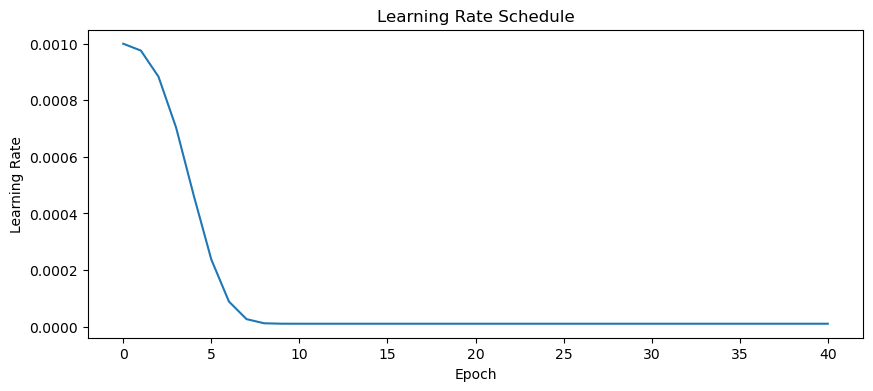

In [22]:
model.evaluate()
test_pred = model.forward(X_test)
test_loss = criterion.forward(test_pred, y_test)
test_r2 = r2_score(y_test, test_pred)

print(f"Test Loss: {test_loss:.4f} | Test R²: {test_r2:.4f}")
print(f"Best Validation Loss: {early_stopping.best_loss:.4f} at epoch {early_stopping.best_epoch+1}")

plt.figure(figsize=(10, 4))
plt.plot(lr_history)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

**Создадим среднюю сеть, используя наши классы и различные функции активации**

In [24]:
import numpy as np

np.random.seed(42)
n_samples = 15000  
n_features = 10
n_targets = 3

X = np.random.randn(n_samples, n_features)
true_weights = np.random.randn(n_features, n_targets)
y = X @ true_weights + 0.1 * np.random.randn(n_samples, n_targets)  

X_train = X[:12000]
X_val = X[12000:13500]
X_test = X[13500:]
y_train = y[:12000]
y_val = y[12000:13500]
y_test = y[13500:]

In [25]:
class MediumRegressionModel(Module):
    def __init__(self, input_size, hidden_size=128, output_size=3, dropout_p=0.3):
        super().__init__()
        self.layers = Sequential()
        
        # Первый скрытый слой
        self.layers.add(Linear(input_size, hidden_size))
        self.layers.add(BatchNormalization())
        self.layers.add(LeakyReLU(slope=0.1))  # Используем LeakyReLU
        self.layers.add(Dropout(dropout_p))
        
        # Второй скрытый слой
        self.layers.add(Linear(hidden_size, hidden_size//2))
        self.layers.add(BatchNormalization())
        self.layers.add(ELU(alpha=1.0))  # Используем ELU
        self.layers.add(Dropout(dropout_p))
        
        # Третий скрытый слой
        self.layers.add(Linear(hidden_size//2, hidden_size//4))
        self.layers.add(BatchNormalization())
        self.layers.add(Gelu())  # Используем Gelu
        self.layers.add(Dropout(dropout_p))
        
        # Выходной слой
        self.layers.add(Linear(hidden_size//4, output_size))
    
    def forward(self, x):
        return self.layers.forward(x)
    
    def backward(self, x, grad_output):
        return self.layers.backward(x, grad_output)

    def getParameters(self):
        """Возвращает список всех параметров модели"""
        params = []
        for module in self.layers.modules:
            if hasattr(module, 'getParameters'):
                params.extend(module.getParameters())
        return params
    
    def setParameters(self, new_params):
        """Устанавливает новые параметры для модели"""
        idx = 0
        for module in self.layers.modules:
            if hasattr(module, 'getParameters'):
                module_params = module.getParameters()
                for i in range(len(module_params)):
                    module_params[i][:] = new_params[idx] 
                    idx += 1

In [26]:
model = MediumRegressionModel(input_size=n_features)
criterion = MSECriterion()
optimizer = Adam(model, lr=0.001)
scheduler = CosineAnnealingLR(optimizer)
early_stopping = EarlyStopping(patience=20, min_delta=0.001)

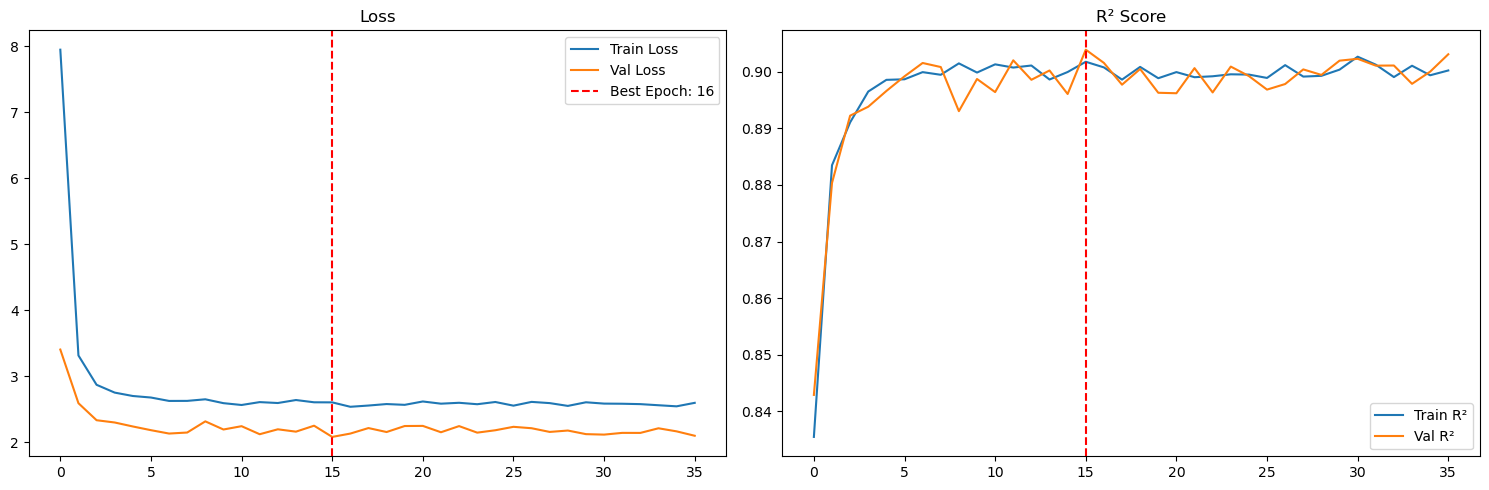

Epoch 36/100
Train Loss: 2.6000 | Val Loss: 2.1012
Train R²: 0.9002 | Val R²: 0.9031
Learning Rate: 0.000010
Best Val Loss: 2.0837 at epoch 16

 Early stopping


In [27]:
batch_size = 64
epochs = 100

train_loss_history = []
val_loss_history = []
train_r2_history = []
val_r2_history = []
lr_history = []

for epoch in range(epochs):
    #Train
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        y_pred = model.forward(X_batch)
        loss = criterion.forward(y_pred, y_batch)
        grad_output = criterion.backward(y_pred, y_batch)
        model.backward(X_batch, grad_output)
        optimizer.step()
        epoch_loss += loss
    
    avg_train_loss = epoch_loss / (len(X_train)/batch_size)
    train_loss_history.append(avg_train_loss)
    
    model.evaluate()
    train_pred = model.forward(X_train)
    train_r2 = r2_score(y_train, train_pred)
    train_r2_history.append(train_r2)
    
    #Validation
    val_pred = model.forward(X_val)
    val_loss = criterion.forward(val_pred, y_val)
    val_loss_history.append(val_loss)
    val_r2 = r2_score(y_val, val_pred)
    val_r2_history.append(val_r2)
    
    #проверка ранней остановки
    early_stopping(model, val_loss, epoch)
    lr_history.append(optimizer.lr)
    
    #шаг шедулера
    scheduler.step()
    
    #отрисовка графиков
    if epoch % 5 == 0 or epoch == epochs-1 or early_stopping.early_stop:
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        #loss
        ax1.plot(train_loss_history, label='Train Loss')
        ax1.plot(val_loss_history, label='Val Loss')
        if early_stopping.best_weights is not None:
            ax1.axvline(early_stopping.best_epoch, color='r', linestyle='--', 
                       label=f'Best Epoch: {early_stopping.best_epoch+1}')
        ax1.set_title('Loss')
        ax1.legend()
        
        #R^2
        ax2.plot(train_r2_history, label='Train R²')
        ax2.plot(val_r2_history, label='Val R²')
        if early_stopping.best_weights is not None:
            ax2.axvline(early_stopping.best_epoch, color='r', linestyle='--')
        ax2.set_title('R² Score')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
        print(f"Learning Rate: {optimizer.lr:.6f}")
        print(f"Best Val Loss: {early_stopping.best_loss:.4f} at epoch {early_stopping.best_epoch+1}")
        
        if early_stopping.early_stop:
            print("\n Early stopping")
            model.setParameters(early_stopping.best_weights)
            break


Test Loss: 2.2272 | Test R²: 0.8973
Best Validation Loss: 2.0837 at epoch 16


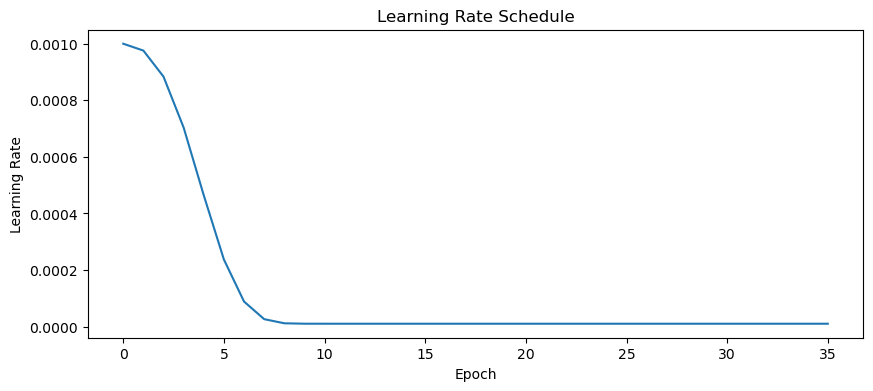

In [28]:
model.evaluate()
test_pred = model.forward(X_test)
test_loss = criterion.forward(test_pred, y_test)
test_r2 = r2_score(y_test, test_pred)

print(f"Test Loss: {test_loss:.4f} | Test R²: {test_r2:.4f}")
print(f"Best Validation Loss: {early_stopping.best_loss:.4f} at epoch {early_stopping.best_epoch+1}")

plt.figure(figsize=(10, 4))
plt.plot(lr_history)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# 3 часть. Реализуем мулитиклассификацию на MNIST

*Загрузим и обработаем данные*

In [31]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data.astype('float32') / 255.0 
y = mnist.target.astype('int')

sample_size = 10000
indices = np.random.choice(len(X), sample_size, replace=False)
X = X[indices]
y = y[indices]

def to_onehot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_onehot = to_onehot(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#проверка размерностей
print("Train shapes:", X_train.shape, y_train.shape)
print("Val shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)
print("Пример метки:", y_train[0], "->", np.argmax(y_train[0]))

Train shapes: (7000, 784) (7000, 10)
Val shapes: (1500, 784) (1500, 10)
Test shapes: (1500, 784) (1500, 10)
Пример метки: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] -> 7


**Создадим сеть, используя наши классы**

In [33]:
class MNISTClassifier(Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=10, dropout_p=0.3):
        super().__init__()
        self.layers = Sequential()
        
        self.layers.add(Linear(input_size, hidden_size))
        self.layers.add(BatchNormalization())
        self.layers.add(ReLU())
        self.layers.add(Dropout(dropout_p))
        
        self.layers.add(Linear(hidden_size, num_classes))
        self.layers.add(SoftMax())
    
    def forward(self, x):
        return self.layers.forward(x)
    
    def backward(self, x, grad_output):
        return self.layers.backward(x, grad_output)
    
    def getParameters(self):
        params = []
        for module in self.layers.modules:
            if hasattr(module, 'getParameters'):
                params.extend(module.getParameters())
        return params
    
    def setParameters(self, new_params):
        idx = 0
        for module in self.layers.modules:
            if hasattr(module, 'getParameters'):
                module_params = module.getParameters()
                for i in range(len(module_params)):
                    module_params[i][:] = new_params[idx]
                    idx += 1

In [34]:
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

**Инициализация модели**

In [36]:
model = MNISTClassifier(input_size=784, hidden_size=256)
criterion = ClassNLLCriterionUnstable()  
optimizer = Adam(model, lr=0.001)
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

*Обучаем модель с отрисовкой лосса и accuracy*

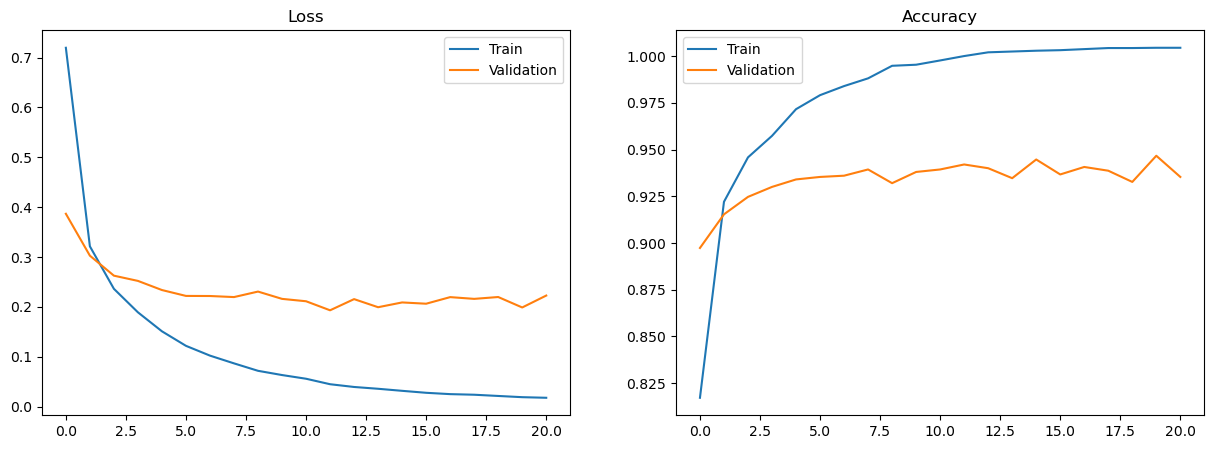

Epoch 21/50
Train Loss: 0.0178 | Val Loss: 0.2227
Train Acc: 1.0044 | Val Acc: 0.9353
Early stopping triggered!


In [38]:
batch_size = 128
epochs = 50

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(epochs):
    #Train
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        y_pred = model.forward(X_batch)
        loss = criterion.forward(y_pred, y_batch)
        grad_output = criterion.backward(y_pred, y_batch)
        model.backward(X_batch, grad_output)
        optimizer.step()
        
        epoch_loss += loss
        epoch_acc += accuracy(y_batch, y_pred)
    
    #Validation
    model.evaluate()
    val_pred = model.forward(X_val)
    val_loss = criterion.forward(val_pred, y_val)
    val_acc = accuracy(y_val, val_pred)
    
    train_loss_history.append(epoch_loss / (len(X_train)/batch_size))
    val_loss_history.append(val_loss)
    train_acc_history.append(epoch_acc / (len(X_train)/batch_size))
    val_acc_history.append(val_acc)
    
    #ранняя остановка
    early_stopping(model, val_loss, epoch)
    if early_stopping.early_stop:
        model.setParameters(early_stopping.best_weights)
        print("Early stopping triggered!")
        break
    
    #визуализация
    if epoch % 5 == 0 or epoch == epochs-1:
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        ax1.plot(train_loss_history, label='Train')
        ax1.plot(val_loss_history, label='Validation')
        ax1.set_title('Loss')
        ax1.legend()
        
        ax2.plot(train_acc_history, label='Train')
        ax2.plot(val_acc_history, label='Validation')
        ax2.set_title('Accuracy')
        ax2.legend()
        
        plt.show()
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss_history[-1]:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc_history[-1]:.4f} | Val Acc: {val_acc:.4f}")

**Выведем лучшую модель и посмотрим на матрицу ошибок**

Test Accuracy: 0.9353
Best Validation Loss: 0.1932


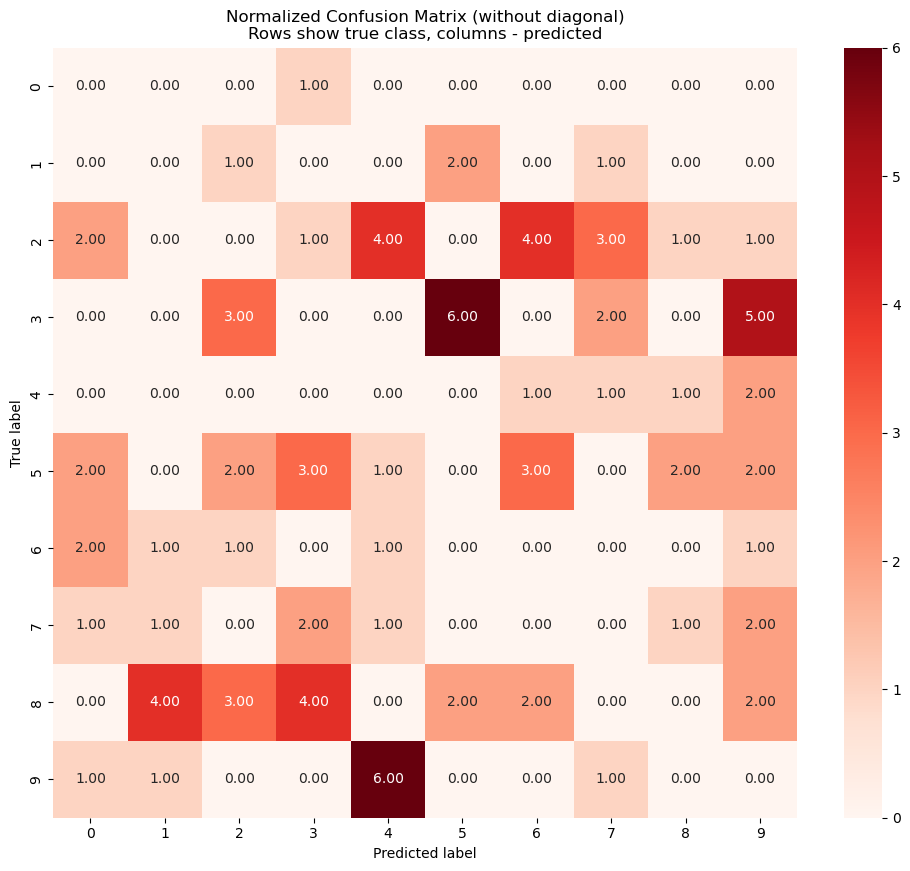

In [40]:
# Тестирование
model.evaluate()
test_pred = model.forward(X_test)
test_acc = accuracy(y_test, test_pred)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Best Validation Loss: {early_stopping.best_loss:.4f}")

#Confusion Matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
cm_norm = cm.astype('float') #/ cm.sum(axis=1)[:, np.newaxis]
np.fill_diagonal(cm_norm, 0)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Reds", 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Normalized Confusion Matrix (without diagonal)\nRows show true class, columns - predicted')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# 4 часть. Реализуем автоэнкодер

**Создадим сеть, используя наши классы**

In [43]:
class Autoencoder(Module):
    def __init__(self, input_size=784, hidden_size=256, latent_dim=32, dropout_p=0.3):
        super().__init__()
        
        #энкодер
        self.encoder = Sequential()
        self.encoder.add(Linear(input_size, hidden_size))
        self.encoder.add(BatchNormalization())
        self.encoder.add(ReLU())
        self.encoder.add(Dropout(dropout_p))
        
        self.encoder.add(Linear(hidden_size, latent_dim))
        self.encoder.add(BatchNormalization())
        self.encoder.add(ReLU())
        
        #декодер
        self.decoder = Sequential()
        self.decoder.add(Linear(latent_dim, hidden_size))
        self.decoder.add(BatchNormalization())
        self.decoder.add(ReLU())
        self.decoder.add(Dropout(dropout_p))
        
        self.decoder.add(Linear(hidden_size, input_size))
        self.decoder.add(ReLU())  

        
        self.layers = Sequential()
        self.layers.modules = self.encoder.modules + self.decoder.modules
    
    def forward(self, x):
        self.encoded = self.encoder.forward(x)
        return self.decoder.forward(self.encoded)
    
    def backward(self, x, grad_output):
        grad_decoder = self.decoder.backward(self.encoded, grad_output)
        return self.encoder.backward(x, grad_decoder)
    
    def getParameters(self):
        return self.encoder.getParameters() + self.decoder.getParameters()

**Инициализация модели**

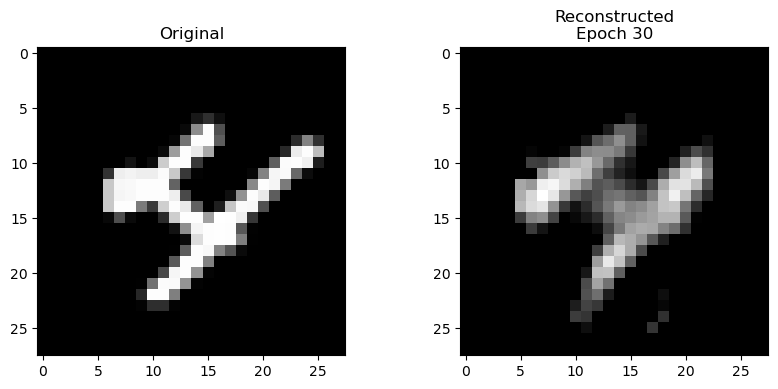

Epoch 30/30 | Train Loss: 13.2363


In [45]:
model = Autoencoder(input_size=784, hidden_size=512, latent_dim=64)
criterion = MSECriterion()
optimizer = Adam(model, lr=0.0005)
batch_size = 128
epochs = 30

#обучение с визуализацией
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i+batch_size]
        
        optimizer.zero_grad()
        reconstructed = model.forward(batch)
        loss = criterion.forward(reconstructed, batch)
        grad = criterion.backward(reconstructed, batch)
        model.backward(batch, grad)
        optimizer.step()
        
        train_loss += loss
    
    #валидация и визуализация
    if epoch % 5 == 0 or epoch == epochs - 1:
        model.evaluate()
        val_reconstructed = model.forward(X_val[:5])
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        
        #оригиналы
        plt.subplot(1, 2, 1)
        plt.imshow(X_val[0].reshape(28, 28), cmap='gray')
        plt.title('Original')
        
        #реконструкция
        plt.subplot(1, 2, 2)
        plt.imshow(val_reconstructed[0].reshape(28, 28), cmap='gray')
        plt.title(f'Reconstructed\nEpoch {epoch+1}')
        
        plt.show()
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/(len(X_train)/batch_size):.4f}")

    